# Indonesian Food Image Classification

## Import Depedencies

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image, UnidentifiedImageError
import os, random, shutil, pathlib, imghdr, cv2
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

/tmp/ipykernel_35/1447558287.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import os, random, shutil, pathlib, imghdr, cv2
2025-06-03 15:11:47.091222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748963507.314992      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748963507.378690      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preparation

### Data Loading

In [ ]:
base_dir = '/kaggle/input/fooddataset'

In [ ]:
ayam_bakar_dir = '/kaggle/input/fooddataset/ayam_bakar'

for image_file in os.listdir(ayam_bakar_dir):
    img_path = os.path.join(ayam_bakar_dir, image_file)
    with Image.open(img_path) as img:
        print(f"{image_file}: {img.size}")  # img.size = (width, height)

ayam bakar (75).jpg: (225, 225)
ayam bakar (165).jpg: (276, 183)
ayam bakar (404).jpg: (327, 154)
ayam bakar (13).jpg: (247, 204)
ayam bakar (122).jpg: (299, 168)
ayam bakar (62).jpg: (225, 225)
ayam bakar (291).jpg: (200, 200)
ayam bakar (49).jpg: (259, 194)
ayam bakar (114).jpg: (216, 233)
ayam bakar (166).jpg: (259, 194)
ayam bakar (199).jpg: (267, 189)
ayam bakar (195).jpg: (265, 190)
ayam bakar (57).jpg: (274, 184)
ayam bakar (292).jpg: (224, 224)
ayam bakar (277).jpg: (224, 224)
ayam bakar (158).jpg: (209, 242)
ayam bakar (260).jpg: (225, 225)
ayam bakar (450).jpg: (267, 189)
ayam bakar (66).jpg: (267, 189)
ayam bakar (93).jpg: (267, 189)
ayam bakar (180).jpg: (225, 225)
ayam bakar (412).jpg: (225, 225)
ayam bakar (63).jpg: (259, 194)
ayam bakar (437).jpg: (267, 189)
ayam bakar (401).jpg: (259, 194)
ayam bakar (110).jpg: (183, 275)
ayam bakar (240).jpg: (267, 189)
ayam bakar (211).jpg: (285, 177)
ayam bakar (411).jpg: (225, 225)
ayam bakar (170).jpg: (258, 195)
ayam bakar (434).j

In [ ]:
class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print(class_names)

['sate', 'mie_goreng', 'bakso', 'sop_buntut', 'martabak_telur', 'rawon', 'nasi_goreng', 'cumi_goreng', 'ayam_semur', 'opor_ayam', 'ayam_bakar', 'bubur', 'rendang', 'nasi_uduk', 'iga_bakar', 'telur_rebus', 'gado_gado', 'telur_dadar', 'ayam_goreng', 'nasi_tumpeng', 'ikan_goreng', 'gulai_ikan', 'soto']


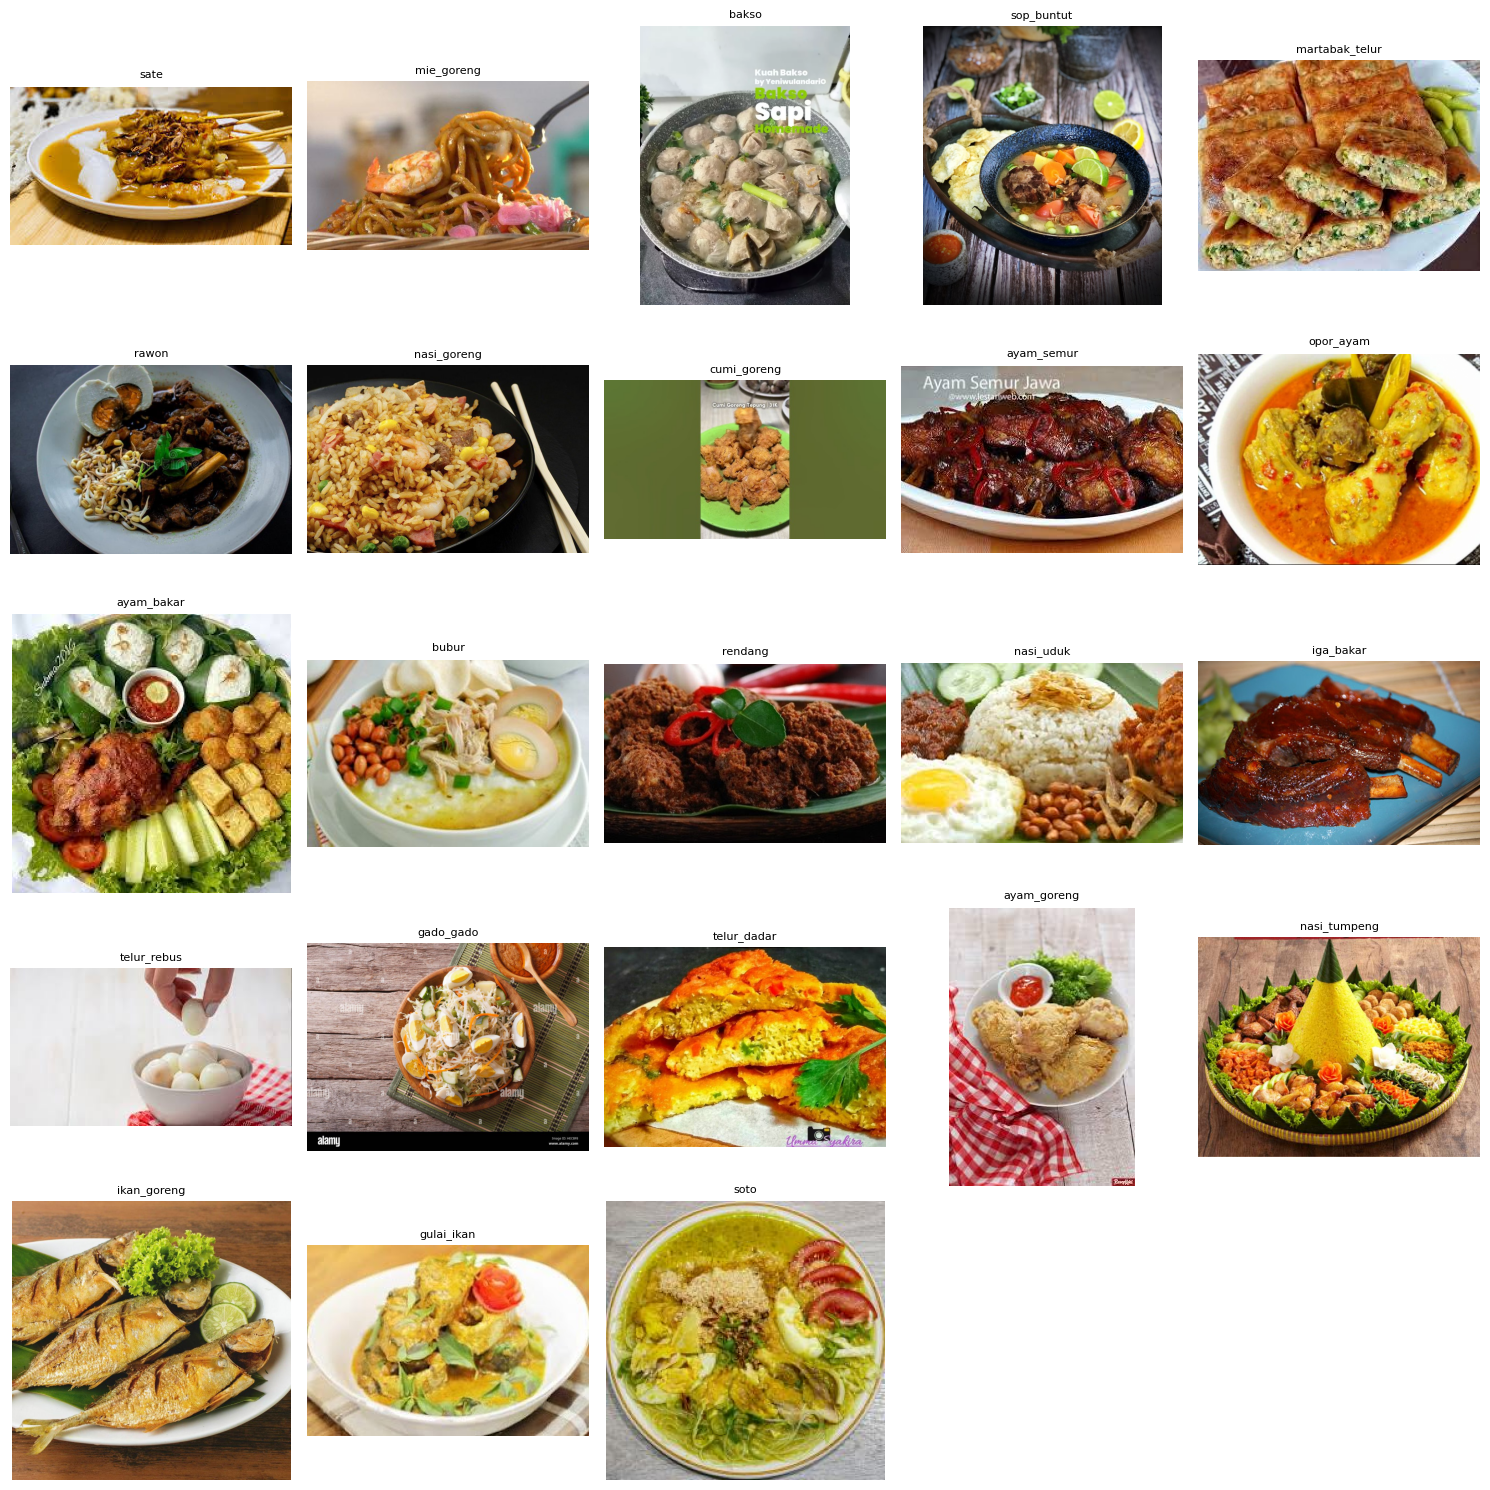

In [ ]:
grid_size = 5
plt.figure(figsize=(grid_size * 3, grid_size * 3))

i = 0
for class_name in class_names:
    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path)]

    if not images:
        continue

    img_name = random.choice(images)
    img_path = os.path.join(class_path, img_name)

    i += 1
    plt.subplot(grid_size, grid_size, i)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(class_name, fontsize=8)
    plt.axis('off')

    if i == grid_size * grid_size:
        break

plt.tight_layout()
plt.show()

### Data Preprocessing

### Data Cleaning

In [ ]:
base_dir = '/kaggle/input/fooddataset'
working_dir = '/kaggle/working/dataset/'

In [ ]:
def copy_dataset(src_dir, dst_dir):
    for root, dirs, files in os.walk(src_dir):
        for name in files:
            if not name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            rel_dir = os.path.relpath(root, src_dir)
            os.makedirs(os.path.join(dst_dir, rel_dir), exist_ok=True)

            src_file = os.path.join(root, name)
            dst_file = os.path.join(dst_dir, rel_dir, name)
            shutil.copy2(src_file, dst_file)

    print("Complete copy dataset.")

In [ ]:
def validate_image(base_dir):
    total_checked = 0
    total_deleted = 0

    for root, _, files in os.walk(base_dir):
        for file in files:
            image_path = os.path.join(root, file)
            total_checked += 1
            try:
                img_raw = tf.io.read_file(image_path)
                _ = tf.io.decode_image(img_raw, channels=3, expand_animations=False)
            except Exception as e:
                print(f'Rusak atau tidak valid: {image_path} — {e}')
                os.remove(image_path)
                total_deleted += 1

    print(f"\nValidasi selesai: {total_deleted}/{total_checked} file dihapus karena rusak.")

In [ ]:
copy_dataset(base_dir, working_dir)
validate_image(working_dir)

Complete copy dataset.


I0000 00:00:1748963589.681758      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748963589.682538      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Validasi selesai: 0/3970 file dihapus karena rusak.


### Split Dataset

In [ ]:
split_dir = '/kaggle/working/split'

# Rasio split dataset
train_ratio = 0.70
val_ratio = 0.20
test_ratio = 0.10

# Seed untuk random shuffle
random.seed(42)

In [ ]:
def split_dataset(base_dir, output_dir):
    class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(output_dir, split)
        os.makedirs(split_path, exist_ok=True)

    for class_name in class_names:
        class_input_path = os.path.join(base_dir, class_name)
        images = [f for f in os.listdir(class_input_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)
        n_test = n_total - n_train - n_val

        train_files = images[:n_train]
        val_files = images[n_train:n_train + n_val]
        test_files = images[n_train + n_val:]

        for split, file_list in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)

            for filename in file_list:
                src = os.path.join(class_input_path, filename)
                dst = os.path.join(split_class_dir, filename)
                shutil.copy2(src, dst)

        print(f"{class_name}: {n_train} train, {n_val} val, {n_test} test")

In [ ]:
split_dataset(working_dir, split_dir)

cumi_goreng: 112 train, 32 val, 16 test
gado_gado: 140 train, 40 val, 20 test
opor_ayam: 112 train, 32 val, 16 test
iga_bakar: 105 train, 30 val, 15 test
nasi_uduk: 115 train, 33 val, 17 test
sop_buntut: 110 train, 31 val, 17 test
ikan_goreng: 140 train, 40 val, 20 test
martabak_telur: 111 train, 31 val, 17 test
rawon: 105 train, 30 val, 15 test
nasi_goreng: 131 train, 37 val, 20 test
ayam_semur: 118 train, 33 val, 18 test
bakso: 109 train, 31 val, 17 test
soto: 139 train, 39 val, 21 test
ayam_bakar: 132 train, 37 val, 20 test
telur_dadar: 118 train, 33 val, 18 test
mie_goreng: 139 train, 39 val, 21 test
gulai_ikan: 105 train, 30 val, 16 test
sate: 137 train, 39 val, 20 test
bubur: 105 train, 30 val, 15 test
nasi_tumpeng: 111 train, 31 val, 17 test
rendang: 136 train, 39 val, 20 test
ayam_goreng: 106 train, 30 val, 16 test
telur_rebus: 136 train, 39 val, 20 test


In [ ]:
train_dir = '/kaggle/working/split/train'
val_dir = '/kaggle/working/split/val'
test_dir = '/kaggle/working/split/test'

In [ ]:
class_counts = {}

for image_class in os.listdir(train_dir):
    class_path = os.path.join(train_dir, image_class)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[image_class] = num_images

# Print jumlah gambar per class
for class_name, count in class_counts.items():
    print(f"Class {class_name}: {count} images")

Class cumi_goreng: 112 images
Class gado_gado: 140 images
Class opor_ayam: 112 images
Class iga_bakar: 105 images
Class nasi_uduk: 115 images
Class sop_buntut: 110 images
Class ikan_goreng: 140 images
Class martabak_telur: 111 images
Class rawon: 105 images
Class nasi_goreng: 131 images
Class ayam_semur: 118 images
Class bakso: 109 images
Class soto: 139 images
Class ayam_bakar: 132 images
Class telur_dadar: 118 images
Class mie_goreng: 139 images
Class gulai_ikan: 105 images
Class sate: 137 images
Class bubur: 105 images
Class nasi_tumpeng: 111 images
Class rendang: 136 images
Class ayam_goreng: 106 images
Class telur_rebus: 136 images


In [ ]:
img_height = 299
img_width = 299
batch_size = 32

In [ ]:
train_ds = image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    shuffle=False
)

test_ds = image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    shuffle=False
)

Found 2772 files belonging to 23 classes.
Found 786 files belonging to 23 classes.
Found 412 files belonging to 23 classes.


### Augmentation and Normalization

In [ ]:
# Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1),
])

# Normalization Layer
data_normalization = tf.keras.layers.Rescaling(1./255)

In [ ]:
# Apply Augmentation and Normalization

train_ds = train_ds.map(lambda x, y: (data_normalization(data_augmentation(x, training=True)),y ))

val_ds = val_ds.map(lambda x, y: (data_normalization(x), y))
test_ds = test_ds.map(lambda x, y: (data_normalization(x), y))

### Optimation Loading

In [ ]:
# Optimasi data loading

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


## Modelling

### Early Stopping

In [ ]:
def create_callbacks():
    # EarlyStopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        verbose=1,
        factor=0.5,
        min_lr=0.00001
    )

    return [early_stopping, learning_rate_reduction]

### Evaluate Model

In [ ]:
def evaluate_model_performance(history, model_name):
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    # Print hasil akhir
    print(f"\nEvaluasi Akhir — {model_name}")
    print(f"Train Accuracy  : {hist['accuracy'][-1]}")
    print(f"Val Accuracy    : {hist['val_accuracy'][-1]}")
    print(f"Train Loss      : {hist['loss'][-1]}")
    print(f"Val Loss        : {hist['val_loss'][-1]}")

    # Plot Loss dan Accuracy
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist['loss'], label='Train Loss')
    plt.plot(epochs, hist['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist['accuracy'], label='Train Acc')
    plt.plot(epochs, hist['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Model Handler

In [ ]:
with strategy.scope():
    model_handler = {
        "inception_v3": tf.keras.applications.InceptionV3(
            include_top=False,
            weights="imagenet",
            input_shape=(img_height, img_width, 3),
        )
    }

    def transfer_learning(model_name, fine_tune=False):
        base_model = model_handler[model_name]
        base_model.trainable = fine_tune

        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(img_height, img_width) + (3,)),
            model_handler[model_name],
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(
                23, activation='softmax',
                kernel_regularizer=tf.keras.regularizers.L2(1e-5),
            )
        ])

        model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )

        return model

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## InceptionV3 Percobaan 2

# New Section

In [ ]:
with strategy.scope():
    inceptionv3_model = transfer_learning("inception_v3", fine_tune=True)

inceptionv3_model.summary()

inceptionv3_model_history = inceptionv3_model.fit(
    train_ds,
    epochs=50,
    callbacks=create_callbacks(),
    validation_data=val_ds
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 23)                  │           2,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,068,023 (84.18 MB)

 Trainable params: 22,033,591 (84.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

Epoch 1/50


I0000 00:00:1748963667.964485     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748963667.964498      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


87/87 ━━━━━━━━━━━━━━━━━━━━ 129s 910ms/step - accuracy: 0.0240 - loss: 3.2779 - val_accuracy: 0.1292 - val_loss: 3.0323 - learning_rate: 1.0000e-04
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 811ms/step - accuracy: 0.0994 - loss: 3.1033 - val_accuracy: 0.1917 - val_loss: 2.9208 - learning_rate: 1.0000e-04
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 72s 825ms/step - accuracy: 0.1038 - loss: 2.9616 - val_accuracy: 0.3022 - val_loss: 2.8110 - learning_rate: 1.0000e-04
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 70s 802ms/step - accuracy: 0.1671 - loss: 2.8967 - val_accuracy: 0.3737 - val_loss: 2.6883 - learning_rate: 1.0000e-04
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 73s 827ms/step - accuracy: 0.1857 - loss: 2.8233 - val_accuracy: 0.4636 - val_loss: 2.5448 - learning_rate: 1.0000e-04
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 72s 818ms/step - accuracy: 0.2799 - loss: 2.6867 - val_accuracy: 0.5222 - val_loss: 2.3697 - learning_rate: 1.0000e-04
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 803ms/step - accuracy: 0.3


Evaluasi Akhir — <Sequential name=sequential_1, built=True>
Train Accuracy  : 0.9319543242454529
Val Accuracy    : 0.9138739109039307
Train Loss      : 0.3026665449142456
Val Loss        : 0.30411121249198914


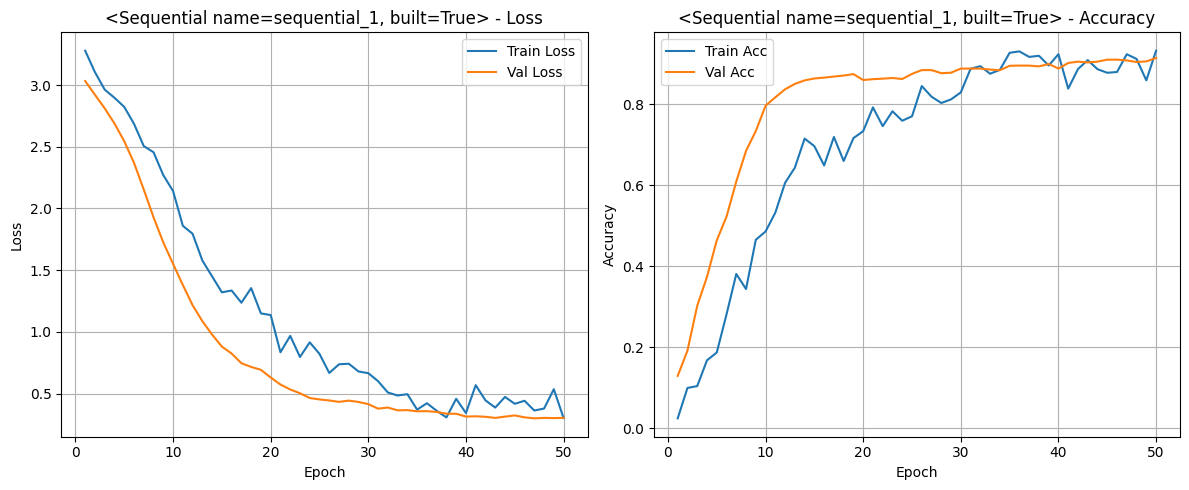

In [ ]:
evaluate_model_performance(inceptionv3_model_history, inceptionv3_model)

In [ ]:
test_loss, test_accuracy = inceptionv3_model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9435 - loss: 0.2138

Test Accuracy: 0.9397
Test Loss: 0.2251


In [ ]:
inceptionv3_model.save("inceptionv3_model.keras", save_format='keras')

## Inference

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [50]:
model = load_model('/content/classification_model.keras')  # ganti path ke model-mu

In [47]:
class_labels = ['ayam_bakar', 'ayam_goreng', 'ayam_semur', 'bakso', 'bubur', 'cumi_goreng', 'gado_gado', 'gulai_ikan', 'iga_bakar', 'ikan_goreng', 'martabak_telur', 'mie_goreng', 'nasi_goreng', 'nasi_tumpeng', 'nasi_uduk', 'opor_ayam', 'rawon', 'rendang', 'sate', 'sop_buntut', 'soto', 'telur_dadar', 'telur_rebus']

In [43]:
def predict_image(image_path):
    # Load dan preprocess gambar
    image = load_img(image_path, target_size=(299, 299))
    img_array = img_to_array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_label = class_labels[predicted_index]
    confidence = predictions[0][predicted_index]

    # Tampilkan hasil
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f})")
    plt.show()

    print(f"Predicted Label : {predicted_label}")
    print(f"Confidence      : {confidence:.4f}")

    return predicted_label, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


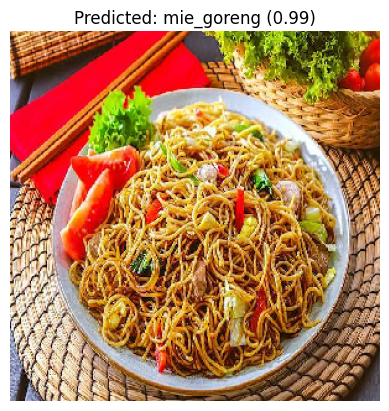

Predicted Label : mie_goreng
Confidence      : 0.9924


('mie_goreng', np.float32(0.99242824))

In [52]:
predict_image('/content/Mie Goreng_053.jpg')